provenance des donnees : https://universe.roboflow.com/roboflow-universe-projects/license-plate-recognition-rxg4e/dataset/4

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import torch
import torchvision
import numpy as np
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torchvision import transforms
from torchvision.io import read_image
from torchvision.utils import draw_bounding_boxes

# Data Exploration

In [13]:
path = "../../../DATA/License_Plate_Recognition/"

train_filenames = [name for name in os.listdir(path + "train/images/")]
test_filenames = [name for name in os.listdir(path + "test/images/")]
validation_filenames = [name for name in os.listdir(path+ "valid/images/")]

In [14]:
#filenames = train_filenames/validation_filenames/test_filenames
#img_dir = path+"/train/images/" / path+"/valid/images/" / path+"/test/images/"
#label_dir = path+"/train/labels/" / path+"/valid/labels/" / path+"/test/labels/"

def recup_coordonnee (path):
    f = open(path)
    contenu = f.read()
    f.close()
    return contenu.split(' ')

def prep_data (coor):
    data=[]
    d=[]
    for i in range (1, len(coor)):
        d.append(float(coor[i].split('\n')[0]))
        if len(d) == 4:
            data.append(d)
            d=[]
    return data

def recup_boxe (path):
    coor = recup_coordonnee (path)
    coor = prep_data (coor)
    if coor:
        return torch.tensor(coor, dtype=torch.float32)
    else:
        # Retourne un tensor 0x4 (0 boîtes, 4 coordonnées)
        return torch.empty(0, 4, dtype=torch.float32)

class CustomImageDataset(Dataset):
    def __init__(self, filenames, img_dir, label_dir, transform=None):
        self.img_labels = filenames
        self.img_dir = img_dir
        self.label_dir = label_dir
        if transform is None:
            self.transform = self.default_transform
        else:
            self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels[idx])
        image = read_image(img_path)
        label_path = os.path.join(self.label_dir, self.img_labels[idx][:-3] + 'txt')
        label = recup_boxe(label_path)
        image = self.transform(image)
        return image, label
    
    def default_transform(self, image_tensor):
        return image_tensor.float() / 255.0

In [15]:
train_dataset = CustomImageDataset(train_filenames, path + "train/images/", path + "train/labels/", transform=None)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = CustomImageDataset(test_filenames, path + "test/images/", path + "test/labels/", transform=None)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

validation_dataset = CustomImageDataset(validation_filenames, path + "valid/images/", path + "valid/labels/", transform=None)
validation_dataloader = DataLoader(validation_dataset, batch_size=32, shuffle=True)

In [ ]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[2].squeeze()
label = train_labels[2]

Feature batch shape: torch.Size([32, 3, 640, 640])
Labels batch shape: torch.Size([32, 1, 4])


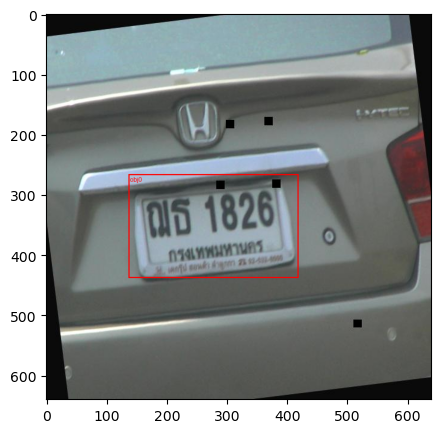

In [21]:
def yolo_xywhn_to_xyxy(cx, cy, w, h, W, H):
    # centre/largeur/hauteur normalisés -> coins en pixels
    x = cx * W
    y = cy * H
    bw = w * W
    bh = h * H
    xmin = x - bw/2
    ymin = y - bh/2
    xmax = x + bw/2
    ymax = y + bh/2
    # clamp dans l'image
    return torch.tensor([
        max(0, xmin), max(0, ymin),
        min(W-1, xmax), min(H-1, ymax)
    ], dtype=torch.float32)

C, H, W = img.shape

boxes_xyxy = torch.stack([yolo_xywhn_to_xyxy(*b, W, H) for b in label], dim=0)  # [N,4]

# draw_bounding_boxes attend uint8 et coords en pixels
img_with_boxes = draw_bounding_boxes(
    image=(img*255.0).to(torch.uint8),
    boxes=boxes_xyxy,
    labels=[f"obj{i}" for i in range(len(label))],  # optionnel
    colors="red",  # optionnel
    width=2
)
fig = plt.figure(figsize=(8, 5))
plt.imshow(img_with_boxes.permute(1, 2, 0))